# Exploratory Data Analysis
# Admissions

## MIMIC-IV dataset 

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import math
import statistics
from scipy import stats
import scipy.stats
from scipy.stats import norm
import plotly.express as px
import seaborn as sns

### Admissions

In [2]:
# Hospital admissions
adm = pd.read_csv('admissions.csv.gz', compression='gzip')

#### Variables

In [3]:
adm.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [4]:
total_adm=len(adm)
total_pat=adm.subject_id.nunique()
ave_adm= round((total_adm/total_pat),2)   #adm["subject_id"].value_counts().mean()
max_adm= adm["subject_id"].value_counts().max()
min_adm = adm["subject_id"].value_counts().min()
dead=adm.deathtime.isnull().value_counts()[1]
dead_rate= round((dead/total_pat)*100,2)


In [5]:
print("There were", total_adm, "hospital admissions from a total number of", total_pat, "patients.") 
print("This gives an average of", ave_adm, "admissions per patient.")
print("However, the maximum mumber of times a patient was admited into the hospital was", max_adm, "and the minimum was",min_adm,".")
print("There was an admission in-hospital mortality rate of", dead_rate, "% (",dead,"patients).")
print()

There were 431231 hospital admissions from a total number of 180733 patients.
This gives an average of 2.39 admissions per patient.
However, the maximum mumber of times a patient was admited into the hospital was 238 and the minimum was 1 .
There was an admission in-hospital mortality rate of 4.76 % ( 8598 patients).



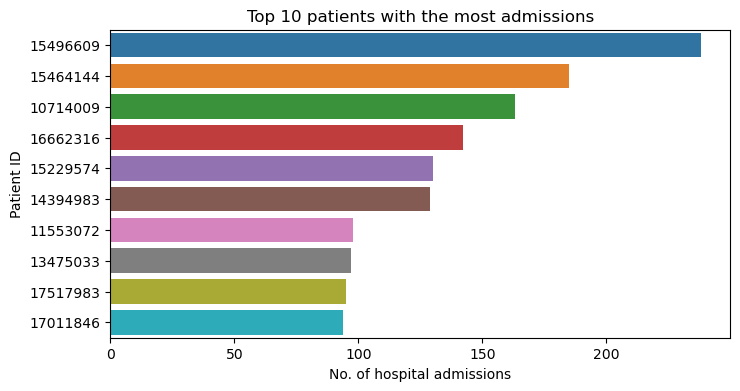

In [6]:
patient = adm['subject_id'].value_counts().head(10).index
plt.figure(figsize=(8, 4))
sns.countplot(data=adm, y='subject_id', order=patient)
plt.title('Top 10 patients with the most admissions')
plt.xlabel('No. of hospital admissions')
plt.ylabel('Patient ID');

The majority of patients are married.


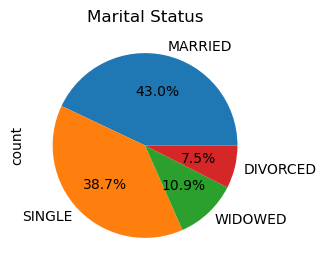

In [7]:
adm.marital_status.value_counts().plot(kind='pie', x='counts', title='Marital Status', autopct="%.1f%%", figsize=(5,3))
print("The majority of patients are married.")

The majority of patients are 'white'.


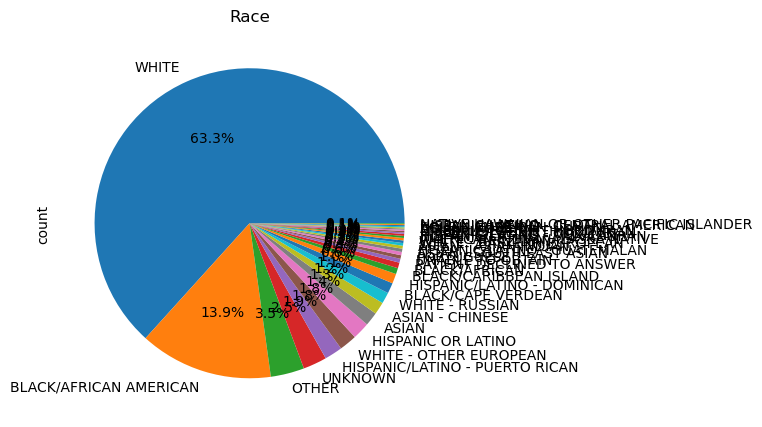

In [8]:
adm.race.value_counts().plot(kind='pie', x='counts', title='Race', autopct="%.1f%%", figsize=(5,6))
print("The majority of patients are 'white'.")

The majority of patients are admited to the hospital as EW Emergency.


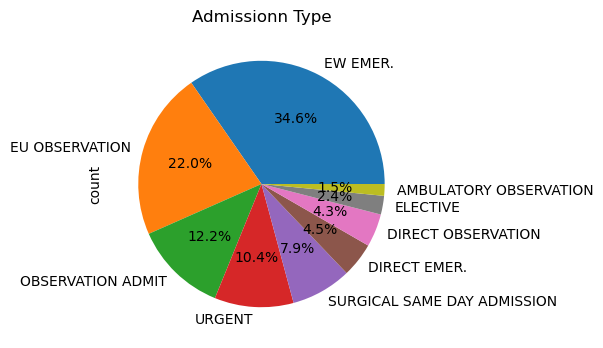

In [9]:
adm.admission_type.value_counts().plot(kind='pie', title="Admissionn Type", autopct="%.1f%%", figsize=(6,4))
print("The majority of patients are admited to the hospital as EW Emergency.")

And so, the majority of patients are admited into the emergency room.


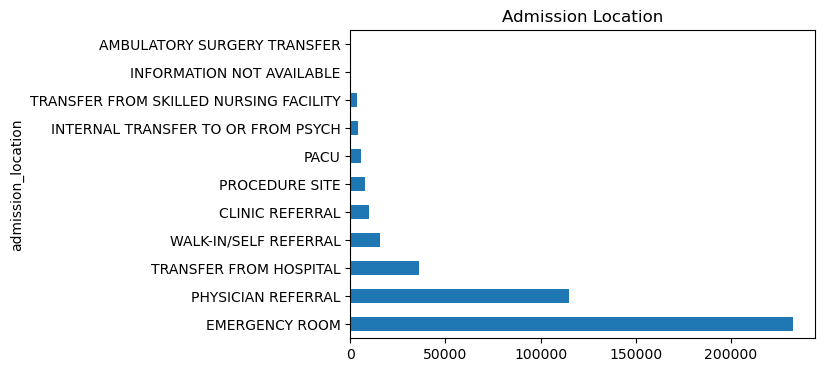

In [10]:
adm.admission_location.value_counts().plot(kind='barh', x="Counts", title='Admission Location', figsize=(6,4))
print("And so, the majority of patients are admited into the emergency room.")

The majority of patients are discharged home after hospital admission.


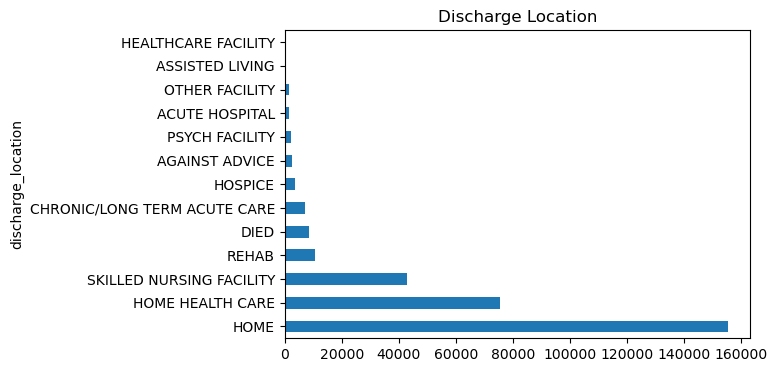

In [11]:
adm.discharge_location.value_counts().plot(kind='barh', title='Discharge Location', figsize=(6,4))
print("The majority of patients are discharged home after hospital admission.")

The majority of patientes that are admitted in the emergency room are discharged home.


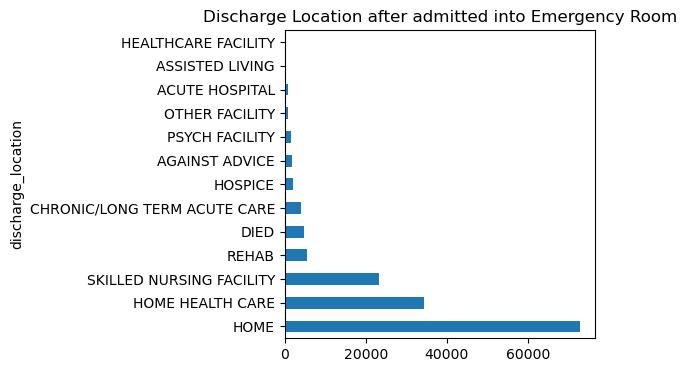

In [12]:
emerg = adm[adm['admission_location']=='EMERGENCY ROOM']['discharge_location'].value_counts()
emerg.plot(kind='barh',figsize=(4,4), title='Discharge Location after admitted into Emergency Room')
print("The majority of patientes that are admitted in the emergency room are discharged home.")

#### Processed data

In [13]:
adm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431231 entries, 0 to 431230
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            431231 non-null  int64 
 1   hadm_id               431231 non-null  int64 
 2   admittime             431231 non-null  object
 3   dischtime             431231 non-null  object
 4   deathtime             8598 non-null    object
 5   admission_type        431231 non-null  object
 6   admit_provider_id     431227 non-null  object
 7   admission_location    431231 non-null  object
 8   discharge_location    312076 non-null  object
 9   insurance             431231 non-null  object
 10  language              431231 non-null  object
 11  marital_status        421998 non-null  object
 12  race                  431231 non-null  object
 13  edregtime             299282 non-null  object
 14  edouttime             299282 non-null  object
 15  hospital_expire_f

In [14]:
# Set dates to date formate and create a new column "staytime" to describe how many days the patient stayed in the hospital/service
adm[['admittime','dischtime','deathtime','edregtime','edouttime']]= adm[['admittime','dischtime','deathtime','edregtime','edouttime']].apply(pd.to_datetime)
adm.insert(4,'staytime_days','')
adm['staytime_days'] = round((adm.dischtime-adm.admittime) / pd.Timedelta("1 days"),2)

In [15]:
adm_= adm[["subject_id", "staytime_days"]]
adm_.head()

,subject_id,staytime_days
0,10000032,0.79
1,10000032,1.02
2,10000032,1.75
3,10000032,2.22
4,10000068,0.30


In [16]:
adm_["staytime_days"].describe()

count    431231.000000
mean          4.483281
std           6.626737
min          -0.950000
25%           1.070000
50%           2.740000
75%           5.240000
max         295.990000
Name: staytime_days, dtype: float64

In [17]:
# Drop columns that seem not important
adm1=adm.drop(columns=['hadm_id','admittime','dischtime','deathtime','admit_provider_id','language','edregtime','edouttime','hospital_expire_flag'])
adm1.head()

,subject_id,staytime_days,admission_type,admission_location,discharge_location,insurance,marital_status,race
0,10000032,0.79,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,WIDOWED,WHITE
1,10000032,1.02,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,WIDOWED,WHITE
2,10000032,1.75,EW EMER.,EMERGENCY ROOM,HOSPICE,Medicaid,WIDOWED,WHITE
3,10000032,2.22,EW EMER.,EMERGENCY ROOM,HOME,Medicaid,WIDOWED,WHITE
4,10000068,0.30,EU OBSERVATION,EMERGENCY ROOM,NaN,Other,SINGLE,WHITE


In [18]:
#Check missing values
adm1.isnull().sum()

subject_id                 0
staytime_days              0
admission_type             0
admission_location         0
discharge_location    119155
insurance                  0
marital_status          9233
race                       0
dtype: int64

In [19]:
# Replace missing values for a category
adm1['discharge_location'] = adm1['discharge_location'].fillna('unknown')
adm1['marital_status'] = adm1['marital_status'].fillna('unknown')
adm1.isnull().sum()

subject_id            0
staytime_days         0
admission_type        0
admission_location    0
discharge_location    0
insurance             0
marital_status        0
race                  0
dtype: int64